In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unzip -q '../Data/glove.42B.300d.txt.zip'

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow import string as tf_string
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.layers import LSTM, GRU, Bidirectional

from sklearn.model_selection import train_test_split #
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, precision_score, recall_score
from sklearn.preprocessing import normalize
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer
from tensorflow.keras.models import Sequential
from keras.layers import Embedding, Dropout, Dense, LSTM, GRU


In [ ]:
dataset = pd.read_csv('../Data/final_dataset_4.csv')

## Split datasetu

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(dataset['processed_text'], dataset['author_id'], test_size=0.20, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

## One-hot encoding

In [ ]:
one_hot_encoder = OneHotEncoder()

y_train = one_hot_encoder.fit_transform(y_train.to_numpy().reshape(-1, 1)).toarray()
y_valid = one_hot_encoder.transform(y_valid.to_numpy().reshape(-1, 1)).toarray()
y_test = one_hot_encoder.transform(y_test.to_numpy().reshape(-1, 1)).toarray()

## Embedding matica

In [ ]:
path_to_glove_file = 'glove.42B.300d.txt'

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 1917494 word vectors.


In [ ]:
embeddings_index['happy'].shape

(300,)

In [ ]:
embedding_dim = 300
vocab_size = 80000
sequence_length = 9000

vect_layer = TextVectorization(max_tokens=vocab_size, output_mode='int', output_sequence_length=sequence_length)
vect_layer.adapt(X_train.values)

In [ ]:
voc = vect_layer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))

In [ ]:
voc[:10]

['', '[UNK]', 's', 'would', 'one', 'could', 'man', 'time', 'upon', 'little']

In [ ]:
num_tokens = len(voc) + 2
hits = 0
misses = 0

embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 62619 words (17381 misses)


# Modely

## Dense model

In [ ]:
input_layer = keras.layers.Input(shape=(1,), dtype=tf_string)
x_v = vect_layer(input_layer)
emb = keras.layers.Embedding(num_tokens, embedding_dim, embeddings_initializer=keras.initializers.Constant(embedding_matrix), trainable=False)(x_v)
x = keras.layers.GlobalAveragePooling1D()(emb)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Dense(1024, activation='relu')(x)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Dense(512, activation='relu')(x)
output_layer =  keras.layers.Dense(y_train.shape[1], activation='softmax')(x)

model = keras.Model(input_layer, output_layer)
model.summary()

model.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 9000)              0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 9000, 300)         24000600  
                                                                 
 global_average_pooling1d (  (None, 300)               0         
 GlobalAveragePooling1D)                                         
                                                                 
 dropout (Dropout)           (None, 300)               0         
                                                                 
 dense (Dense)               (None, 1024)              308224

In [ ]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='glove_weights.best.tf.weights.h5',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

In [ ]:
batch_size = 32
epochs = 15

history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), callbacks=[model_checkpoint_callback], epochs=epochs, batch_size=batch_size)

Epoch 1/15
28/28 [==============================] - 231s 8s/step - loss: 2.9041 - accuracy: 0.0746 - val_loss: 2.7759 - val_accuracy: 0.1649
Epoch 2/15
28/28 [==============================] - 207s 8s/step - loss: 2.6008 - accuracy: 0.2698 - val_loss: 2.3907 - val_accuracy: 0.2680
Epoch 3/15
28/28 [==============================] - 206s 8s/step - loss: 2.0910 - accuracy: 0.4156 - val_loss: 1.9593 - val_accuracy: 0.4330
Epoch 4/15
28/28 [==============================] - 204s 8s/step - loss: 1.6320 - accuracy: 0.5189 - val_loss: 1.5462 - val_accuracy: 0.4742
Epoch 5/15
28/28 [==============================] - 206s 8s/step - loss: 1.4070 - accuracy: 0.5798 - val_loss: 1.5189 - val_accuracy: 0.5052
Epoch 6/15
28/28 [==============================] - 205s 8s/step - loss: 1.1771 - accuracy: 0.6544 - val_loss: 1.2060 - val_accuracy: 0.7526
Epoch 7/15
28/28 [==============================] - 205s 8s/step - loss: 1.0635 - accuracy: 0.6544 - val_loss: 1.0886 - val_accuracy: 0.7010
Epoch 8/15
28

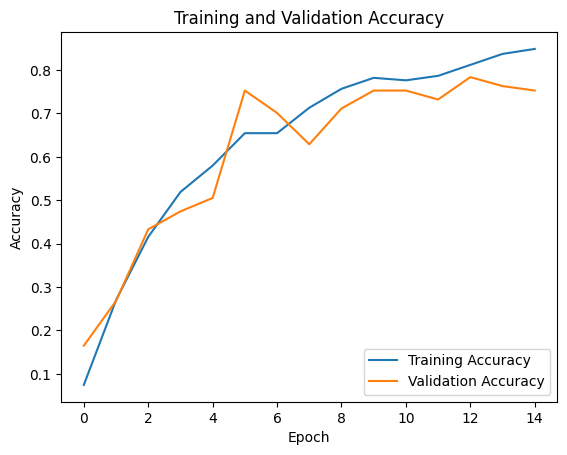

In [ ]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

In [ ]:
model.evaluate(X_test, y_test)
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_test_ = np.argmax(y_test, axis=1)

8/8 [==============================] - 1s 63ms/step


In [ ]:
accuracy_sc = accuracy_score(y_pred=y_pred,y_true=y_test_)
f1_sc = f1_score(y_pred=y_pred, y_true=y_test_, average='weighted')
precision_sc = precision_score(y_pred=y_pred, y_true=y_test_, average='weighted', zero_division = 0)
recall_sc = recall_score(y_pred=y_pred, y_true=y_test_, average='weighted')

print(f"Accuracy: {accuracy_sc}")
print(f"F1 Score: {f1_sc}")
print(f"Precision: {precision_sc}")
print(f"Recall: {recall_sc}")

Accuracy: 0.8677685950413223
F1 Score: 0.8664854611039153
Precision: 0.8784158162773865
Recall: 0.8677685950413223


## CNN Model

In [ ]:
input_layer = keras.layers.Input(shape=(1,), dtype=tf.string)
x_v = vect_layer(input_layer)
emb = keras.layers.Embedding(num_tokens, embedding_dim, embeddings_initializer=keras.initializers.Constant(embedding_matrix), trainable=False)(x_v)
x = tf.keras.layers.Conv1D(512, kernel_size=4, padding="valid", activation="relu")(emb)
x = tf.keras.layers.MaxPooling1D(pool_size=2)(x)
x = tf.keras.layers.GlobalAveragePooling1D()(x)
x = tf.keras.layers.Dense(256, activation="relu")(x)
x = tf.keras.layers.Dropout(0.2)(x)
output_layer = Dense(y_train.shape[1], activation='softmax')(x)

model = keras.Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 9000)              0         
 ctorization)                                                    
                                                                 
 embedding_1 (Embedding)     (None, 9000, 300)         24000600  
                                                                 
 conv1d (Conv1D)             (None, 8997, 512)         614912    
                                                                 
 max_pooling1d (MaxPooling1  (None, 4498, 512)         0         
 D)                                                              
                                                                 
 global_average_pooling1d_1  (None, 512)               0   

In [ ]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='glove_weights.best.tf.weights.h5',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

In [ ]:
batch_size = 32
epochs = 15

history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), callbacks=[model_checkpoint_callback], epochs=epochs, batch_size=batch_size)

Epoch 1/15
28/28 [==============================] - 223s 8s/step - loss: 2.8812 - accuracy: 0.1056 - val_loss: 2.7142 - val_accuracy: 0.1649
Epoch 2/15
28/28 [==============================] - 212s 8s/step - loss: 2.5450 - accuracy: 0.2549 - val_loss: 2.3730 - val_accuracy: 0.2371
Epoch 3/15
28/28 [==============================] - 211s 8s/step - loss: 2.1707 - accuracy: 0.3502 - val_loss: 2.0174 - val_accuracy: 0.4742
Epoch 4/15
28/28 [==============================] - 216s 8s/step - loss: 1.9104 - accuracy: 0.4696 - val_loss: 1.7048 - val_accuracy: 0.5464
Epoch 5/15
28/28 [==============================] - 217s 8s/step - loss: 1.6544 - accuracy: 0.5545 - val_loss: 1.5792 - val_accuracy: 0.5464
Epoch 6/15
28/28 [==============================] - 218s 8s/step - loss: 1.4557 - accuracy: 0.6085 - val_loss: 1.4201 - val_accuracy: 0.5876
Epoch 7/15
28/28 [==============================] - 215s 8s/step - loss: 1.3064 - accuracy: 0.6521 - val_loss: 1.1889 - val_accuracy: 0.7320
Epoch 8/15
28

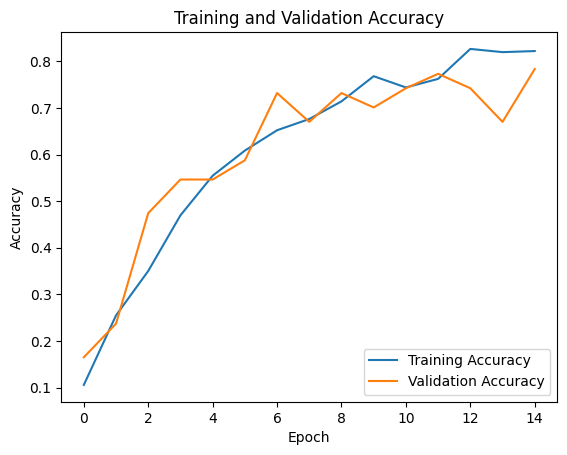

In [ ]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

In [ ]:
model.evaluate(X_test, y_test)
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_test_ = np.argmax(y_test, axis=1)

8/8 [==============================] - 1s 160ms/step


In [ ]:
accuracy_sc = accuracy_score(y_pred=y_pred,y_true=y_test_)
f1_sc = f1_score(y_pred=y_pred, y_true=y_test_, average='weighted')
precision_sc = precision_score(y_pred=y_pred, y_true=y_test_, average='weighted', zero_division = 0)
recall_sc = recall_score(y_pred=y_pred, y_true=y_test_, average='weighted')

print(f"Accuracy: {accuracy_sc}")
print(f"F1 Score: {f1_sc}")
print(f"Precision: {precision_sc}")
print(f"Recall: {recall_sc}")

Accuracy: 0.8553719008264463
F1 Score: 0.8546953648243191
Precision: 0.8693764454095032
Recall: 0.8553719008264463


## Biderectional LSTMU

In [ ]:
input_layer = keras.layers.Input(shape=(1,), dtype=tf_string)
x_v = vect_layer(input_layer)
emb = keras.layers.Embedding(num_tokens, embedding_dim, embeddings_initializer=keras.initializers.Constant(embedding_matrix), trainable=False)(x_v)
x = keras.layers.Bidirectional(keras.layers.LSTM(128, return_sequences=True))(emb)
x = keras.layers.GlobalAveragePooling1D()(x)
x = keras.layers.Dense(256, 'relu')(x)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Dense(128, 'relu')(x)
x = keras.layers.Dropout(0.2)(x)
output_layer = keras.layers.Dense(y_train.shape[1], activation='softmax')(x)

model = keras.Model(input_layer, output_layer)
model.summary()


model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 9000)              0         
 ctorization)                                                    
                                                                 
 embedding_2 (Embedding)     (None, 9000, 300)         24000600  
                                                                 
 bidirectional (Bidirection  (None, 9000, 256)         439296    
 al)                                                             
                                                                 
 global_average_pooling1d_2  (None, 256)               0         
  (GlobalAveragePooling1D)                                       
                                                           

In [ ]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='glove_weights.best.tf.weights.h5',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

In [ ]:
batch_size = 32
epochs = 15

history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), callbacks=[model_checkpoint_callback], epochs=epochs, batch_size=batch_size)

Epoch 1/15
28/28 [==============================] - 232s 8s/step - loss: 2.9328 - accuracy: 0.0746 - val_loss: 2.8710 - val_accuracy: 0.0928
Epoch 2/15
28/28 [==============================] - 224s 8s/step - loss: 2.5385 - accuracy: 0.2135 - val_loss: 2.3549 - val_accuracy: 0.1856
Epoch 3/15
28/28 [==============================] - 226s 8s/step - loss: 2.1530 - accuracy: 0.3249 - val_loss: 2.1087 - val_accuracy: 0.2577
Epoch 4/15
28/28 [==============================] - 228s 8s/step - loss: 1.8265 - accuracy: 0.4041 - val_loss: 1.7886 - val_accuracy: 0.4845
Epoch 5/15
28/28 [==============================] - 222s 8s/step - loss: 1.7585 - accuracy: 0.4432 - val_loss: 1.7600 - val_accuracy: 0.4536
Epoch 6/15
28/28 [==============================] - 218s 8s/step - loss: 1.5299 - accuracy: 0.5086 - val_loss: 1.4646 - val_accuracy: 0.5567
Epoch 7/15
28/28 [==============================] - 220s 8s/step - loss: 1.3169 - accuracy: 0.5763 - val_loss: 1.3974 - val_accuracy: 0.5876
Epoch 8/15
28

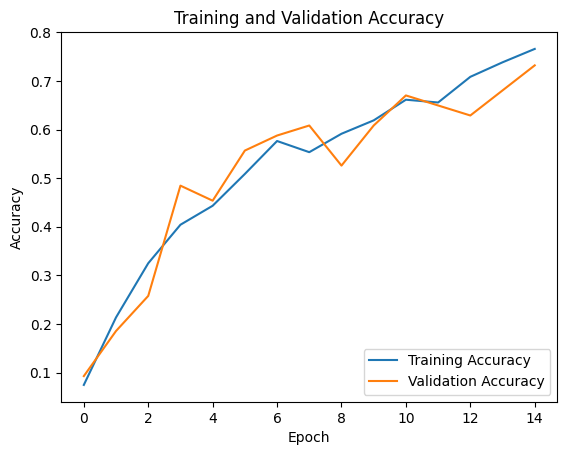

In [ ]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

In [ ]:
model.evaluate(X_test, y_test)
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_test_ = np.argmax(y_test, axis=1)

8/8 [==============================] - 3s 282ms/step


In [ ]:
accuracy_sc = accuracy_score(y_pred=y_pred,y_true=y_test_)
f1_sc = f1_score(y_pred=y_pred, y_true=y_test_, average='weighted')
precision_sc = precision_score(y_pred=y_pred, y_true=y_test_, average='weighted', zero_division = 0)
recall_sc = recall_score(y_pred=y_pred, y_true=y_test_, average='weighted')

print(f"Accuracy: {accuracy_sc}")
print(f"F1 Score: {f1_sc}")
print(f"Precision: {precision_sc}")
print(f"Recall: {recall_sc}")

Accuracy: 0.7768595041322314
F1 Score: 0.7713601174153495
Precision: 0.784871544892206
Recall: 0.7768595041322314


## LSTM + GRU

In [ ]:
input_layer = keras.layers.Input(shape=(1,), dtype=tf_string)
x_v = vect_layer(input_layer)
emb = keras.layers.Embedding(num_tokens, embedding_dim, embeddings_initializer=keras.initializers.Constant(embedding_matrix), trainable=False)(x_v)
x = keras.layers.LSTM(256, return_sequences=True)(emb)
x = keras.layers.Dropout(0.1)(x)
x = keras.layers.GRU(128, return_sequences=False)(x)
x = keras.layers.Dropout(0.1)(x)
x = keras.layers.Dense(64, 'relu')(x)
x = keras.layers.Dense(32, 'relu')(x)
x = keras.layers.Dropout(0.1)(x)
output_layer = keras.layers.Dense(y_train.shape[1], activation='softmax')(x)


model = keras.Model(input_layer, output_layer)
model.summary()


model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 9000)              0         
 ctorization)                                                    
                                                                 
 embedding_3 (Embedding)     (None, 9000, 300)         24000600  
                                                                 
 lstm_1 (LSTM)               (None, 9000, 256)         570368    
                                                                 
 dropout_5 (Dropout)         (None, 9000, 256)         0         
                                                                 
 gru (GRU)                   (None, 128)               148224    
                                                           

In [ ]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='glove_weights.best.tf.weights.h5',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

In [ ]:
batch_size = 32
epochs = 15

history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), callbacks=[model_checkpoint_callback], epochs=epochs, batch_size=batch_size)

Epoch 1/15
28/28 [==============================] - 232s 8s/step - loss: 2.9690 - accuracy: 0.0746 - val_loss: 2.9541 - val_accuracy: 0.0515
Epoch 2/15
28/28 [==============================] - 226s 8s/step - loss: 2.8781 - accuracy: 0.0700 - val_loss: 2.9456 - val_accuracy: 0.0619
Epoch 3/15
28/28 [==============================] - 226s 8s/step - loss: 2.7768 - accuracy: 0.1194 - val_loss: 2.8373 - val_accuracy: 0.0825
Epoch 4/15
28/28 [==============================] - 226s 8s/step - loss: 2.6361 - accuracy: 0.1780 - val_loss: 2.8211 - val_accuracy: 0.1340
Epoch 5/15
28/28 [==============================] - 25s 875ms/step - loss: 2.5522 - accuracy: 0.1883 - val_loss: 2.9277 - val_accuracy: 0.0825
Epoch 6/15
28/28 [==============================] - 23s 828ms/step - loss: 2.4341 - accuracy: 0.2113 - val_loss: 2.8955 - val_accuracy: 0.1340
Epoch 7/15
28/28 [==============================] - 24s 878ms/step - loss: 2.2753 - accuracy: 0.2618 - val_loss: 3.0172 - val_accuracy: 0.1649
Epoch 8

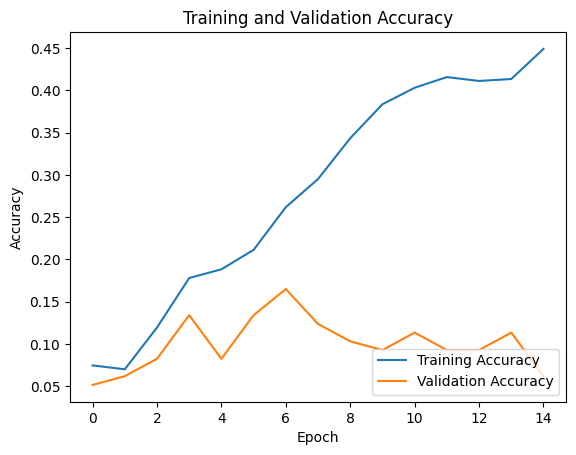

In [ ]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

In [ ]:
model.evaluate(X_test, y_test)
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_test_ = np.argmax(y_test, axis=1)

8/8 [==============================] - 4s 362ms/step


In [ ]:
accuracy_sc = accuracy_score(y_pred=y_pred,y_true=y_test_)
f1_sc = f1_score(y_pred=y_pred, y_true=y_test_, average='weighted')
precision_sc = precision_score(y_pred=y_pred, y_true=y_test_, average='weighted', zero_division = 0)
recall_sc = recall_score(y_pred=y_pred, y_true=y_test_, average='weighted')

print(f"Accuracy: {accuracy_sc}")
print(f"F1 Score: {f1_sc}")
print(f"Precision: {precision_sc}")
print(f"Recall: {recall_sc}")

Accuracy: 0.11983471074380166
F1 Score: 0.10576252325344883
Precision: 0.1991644125333965
Recall: 0.11983471074380166
